#Clasificación de Texto con Pytorch (Bag of Words) 

Referencias

https://github.com/scoutbee/pytorch-nlp-notebooks


https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb

https://towardsdatascience.com/sentiment-classification-using-logistic-regression-in-pytorch-e0c43de9eb66

https://www.freecodecamp.org/news/sentiment-analysis-with-text-mining/

https://kavita-ganesan.com/how-to-use-countvectorizer/#.YCH2amhKi00

https://www.youtube.com/watch?v=4jROlXH9Nvc&ab_channel=CodingTech

##Problema a Resolver
En este notebook trataremos de realizar un clasficador de textos (sentiment analysis) para una base de datos de Tweets de Demócratas y Republicanos, los cuales son los dos partidos políticos de Estados Unidos. El objetivo será hacer el clasificador de textos con una red neuronal hecha en Pytorch y usando el modelo Bag of Words para poder procesar los datos, cabe destacar que esta tarea también representa cierta dificultad incluso para un ser humano, el identificar si un comentario es Demócrata o Republicano sin el contexto puede llegar a ser dificil.

## Impotación de paqueterias

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)


import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, tqdm_notebook


from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer


import re




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Correr en GPU
device

device(type='cuda')

##Cargamos la base de datos
https://www.kaggle.com/kapastor/democratvsrepublicantweets?select=ExtractedTweets.csv



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/ProyectoFinalPytorch/ExtractedTweets.csv')

En este caso el input será el Tweet y el output será el partido político, sin embargo el tweet no puede ser procesado como se muestra, todavía debe de cambiarse de representación 

In [ ]:
df.head(10)

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L"
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurricane Maria has left approximately $90 billion in damages. \n\nCongress has allocated about $18…
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto . Thanks for taking the time to meet with @LatinoLeader ED Marucci Guzman. #NALCABPolicy2018.…
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June 1st; Puerto Rico’s readiness...well 🤦🏼‍♂️😡😩@Pwr4PuertoRico @RepDarrenSoto @EspaillatNY
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came out to our Orlando gala! It was a successful night that would not have been possible without…
6,Democrat,RepDarrenSoto,"Hurricane Maria left approx $90 billion in damages, yet only $1 billion was allocated for rebuilding grid. No surpr… https://t.co/2kU8BcKwUh"
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSoto will be voting for the CRA to overrule the FCC and save our #NetNeutrality rules. Find out…
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant policies are hurting small businesses across the country that can’t find Americans willing to do…
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidosUS and @RepDarrenSoto for a roundtable in #Orlando on federal issues affecting central Florid…


##Agregamos una nueva columna condicional 0 si es Demócrata y 1 si es Republicano


In [ ]:
df['label'] = [0 if x =='Democrat' else 1 for x in df['Party']] 
df.sample(10)

,Party,Handle,Tweet,label
56034,Republican,RepWalorski,RT @RV_Industry: Big strides were made last night as the House of Representatives passed a three-year extension of the #GSP program by a vo…,1
35929,Democrat,RepBrianHiggins,Spoke about Western New York's efforts to embrace what is naturally ours and the important role of New Markets and… https://t.co/L4YvfeSDAf,0
66900,Republican,RepHartzler,"Meet Machie and Annalisa Limas, who own @StateFairFloral in Sedalia! In honor of Small Business Week, Machie and An… https://t.co/4Q69XoEquf",1
64884,Republican,RepCharlieDent,🙏Thank you for the opportunity--what a great group of students! #PA15Proud https://t.co/gvBXytMpBS,1
54049,Republican,HouseJudiciary,".@RepGoodlatte speaking in favor of the ""ADA Education and Reform Act"": the bottom line is ""more access for more Americans more quickly.""",1
77733,Republican,TomRooney,"RT @TomRooney: Thanks to @mikiebarb for a great, thoughtful interview. https://t.co/5EIAcLJTbY",1
74033,Republican,RepMimiWalters,"In today’s @HouseCommerce #SubOversight hearing, I questioned the @DEAHQ Acting Administrator on the urgency for im… https://t.co/nkdQe6SN6m",1
32750,Democrat,GerryConnolly,Speaking to @tysonspartners @fairfaxcounty Tysons Open House this evening. What is happening in Tysons is truly tra… https://t.co/Fbz6WQAZeO,0
38313,Democrat,janschakowsky,RT @Maine_South: C team in action today at the energy and commerce meeting room in DC \n#207Now https://t.co/OVKGEmo2k1,0
70165,Republican,RepDavid,"Appreciate the honor, @adam_brandon &amp; @FreedomWorks! https://t.co/F1RrUo98e8",1


In [ ]:
df['Party'].value_counts()

Republican    44392
Democrat      42068
Name: Party, dtype: int64

In [ ]:
df['Handle'].value_counts()

rosadelauro        200
Robert_Aderholt    200
RepThomasMassie    200
PeteSessions       200
RepTomGraves       200
                  ... 
HouseAdmnGOP       199
RepStephMurphy     199
RepVisclosky       197
Jim_Jordan         197
collinpeterson     80 
Name: Handle, Length: 433, dtype: int64

##Visulización de Datos


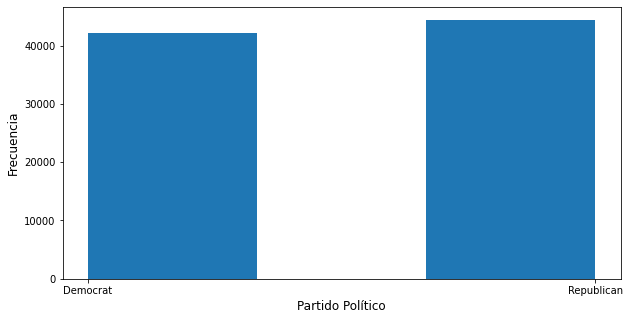

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5)) 
plt.hist(df.Party, bins=3,)
plt.xlabel('Partido Político',size=12)
plt.ylabel('Frecuencia',size=12)
plt.show()

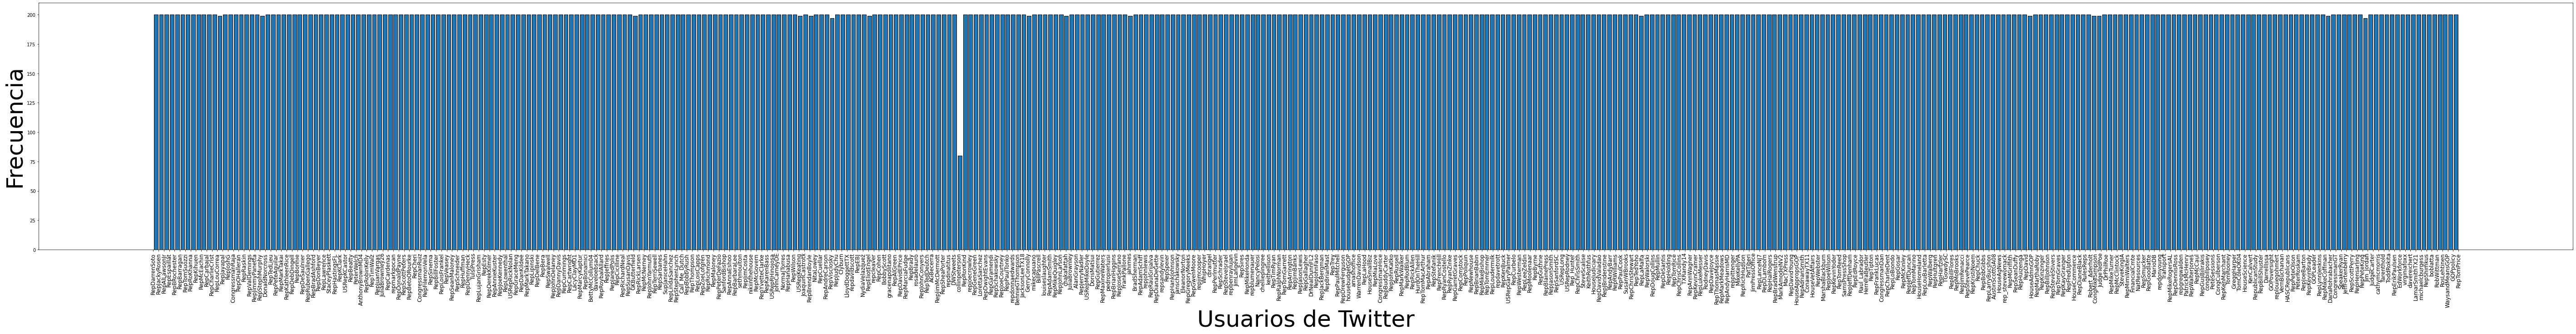

In [ ]:
plt.figure(figsize=(100,10)) 
plt.hist(df.Handle, bins=433,edgecolor='black',rwidth=0.75)
plt.xlabel('Usuarios de Twitter',size=50)
plt.ylabel('Frecuencia',size=50)
plt.xticks(rotation='vertical',size=12)
plt.show()

##Limpeza de los datos

In [ ]:

df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])# Remueve los links
df['Tweet'] = df['Tweet'].str.replace('\d+', '')#Remueve los números
df['Tweet'] = df['Tweet'].str.replace(r'[^\w\s]+', '') #Remueve todos los signos de puntuación
df['Tweet'] = df['Tweet'].str.replace('@', '')
df['Tweet'] = df['Tweet'].str.replace('RT', '') #Remueve RT
df['Tweet'] = df['Tweet'].str.replace('\n', '')
df['Tweet'] = df['Tweet'].str.lower()# Se vuelve todo a minúsculas

df.head()

,Party,Handle,Tweet,label
0,Democrat,RepDarrenSoto,today senate dems vote to savetheinternet proud to support similar netneutrality legislation here in the house,0
1,Democrat,RepDarrenSoto,winterhavensun winter haven resident alta vista teacher is one of several recognized by repdarrensoto for national teacher apprecia,0
2,Democrat,RepDarrenSoto,nbclatino repdarrensoto noted that hurricane maria has left approximately billion in damages congress has allocated about,0
3,Democrat,RepDarrenSoto,nalcabpolicy meeting with repdarrensoto thanks for taking the time to meet with latinoleader ed marucci guzman nalcabpolicy,0
4,Democrat,RepDarrenSoto,vegalteno hurricane season starts on june st puerto ricos readinesswell pwrpuertorico repdarrensoto espaillatny,0


In [ ]:
df.sample(20)

,Party,Handle,Tweet,label
48127,Republican,RepFrenchHill,more benefits from taxreform as we see entergyark commit to lowering the utility rates for hardworking arkansans,1
52720,Republican,USRepLong,the bright red rig is a rolling memorial to firefighters everywhere and especially three area heroes who died pro,1
57672,Republican,RepKevinCramer,tomorrow my staff is holding mobile office hours in fort yates and carson click the link below for details,1
63244,Republican,RepTomReed,thanks to theciab for having repjoshg and me speak about the problemsolvers caucus at their legislative summit,1
1290,Democrat,RepTomSuozzi,newsdayopinion its our responsibility to help them and we encourage young people on long island and throughout the nation to suppo,0
74942,Republican,MarioDB,actualidadradio actualidad nicaragua mariodb a robertoejera juancamilogg y msfernandanews la ley nica pasará audio gt h,1
49329,Republican,RepNewhouse,foodtank there arent that many farmers in congress and we have two of them here hbottemiller from politico in a live fireside c,1
52649,Republican,RepSanfordSC,every single coastal municipality in south carolina and over coastal municipalities on the east coast have,1
16791,Democrat,daveloebsack,it was my pleasure to meet you and your employees thanks for the tour,0
57145,Republican,RepChrisCollins,happy to hear jimkelly surgery went well wishing you a speedy recovery bills kellytough,1


##Reordenamos los datos 

In [ ]:
df = df.sample(frac=1)
df.head(10)

,Party,Handle,Tweet,label
39104,Democrat,repjimcooper,we should have addressed our transit issues decades ago the longer we wait the harder it is now is the time to s,0
20170,Democrat,RepBobbyRush,but politicians are calling for more accountability rep rush sent a letter to the facebook cofounder after the,0
4483,Democrat,RepTedLieu,welcome to the neighborhood latimes looking forward to seeing you in ca,0
42588,Republican,RepArrington,our prayers are with mrs bush and her family as they wrestle with her failing health my heart is heavy especially,1
3196,Democrat,CongressmanRaja,this is a profound testimony to our failure to make the american dream a reality for all of our citizens president,0
682,Democrat,RepEspaillat,as early as the spring of the trump administration has considered separating children from immigrant parents,0
24158,Democrat,RepWilson,we have to figure out what happens between the time when the umbilical cord is cut and when the child picks up a g,0
47057,Republican,RepRodBlum,gopleader you deserve the truth here is why the fisa memo matters,1
13334,Democrat,RepLowenthal,scott pruitt has consistently put special interests ahead of the public he has put ideology ahead of science i ha,0
71917,Republican,HouseCommerce,hr enhancing grid security through publicprivate partnerships act as amended has passed the fullcmte by voice vote,1


In [ ]:
df.describe()

,label
count,86460.000000
mean,0.513440
std,0.499822
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


##Dividimos los datos

In [ ]:
test_ratio = 0.1

train_ratio = int((1.0-test_ratio)*len(df.values[:,:]))

df_train = df.iloc[0:train_ratio,:]
df_test  = df.iloc[train_ratio:,:]

print(df_train.shape)
print(df_test.shape)



(77814, 4)
(8646, 4)


##Modelo de Bolsa de Palabras (Bag of Words)

Primera manera de verlo

<img src='https://drive.google.com/uc?id=1noyU6vVGPidmfTtdAU3HBVU5nORw8mtB' align = "center">




<img src='https://drive.google.com/uc?id=1DI4ID0aUmJolmHU-XjKR7e7ZFh72CN-9' align = "center">



Otra manera de verlo

<img src='https://drive.google.com/uc?id=1wRpmrzL4WKKKo-c9eGBFY7J9NWG3Z0Jp' align = "center">


<img src='https://drive.google.com/uc?id=1rQy083gzqUpqiNC3odSedxxeQv8fEEzJ' align = "center">

In [ ]:
df_train["Tweet"].tolist()

In [ ]:
print(df_train["Tweet"].tolist())
cv = CountVectorizer(df_train["Tweet"].tolist(), stop_words='english', max_df=0.99, min_df=0.005)
count_vector=cv.fit_transform(df_train["Tweet"].tolist())
cv.vocabulary_

In [ ]:
class Sequences(Dataset):
    def __init__(self, path):
        df = path        
        self.vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.005)
        self.sequences = self.vectorizer.fit_transform(df.Tweet.tolist())
        self.labels = df.label.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [ ]:
dataset = Sequences(df_train)


print(dataset.token2idx)
print(dataset.idx2token)
print(dataset[15][0].shape)
dataset[15][0]


{'issues': 130, 'ago': 6, 'time': 258, 'rep': 206, 'letter': 145, 'facebook': 80, 'looking': 153, 'forward': 86, 'ca': 28, 'prayers': 192, 'family': 82, 'health': 106, 'make': 155, 'american': 9, 'president': 193, 'trump': 264, 'administration': 4, 'children': 36, 'deserve': 63, 'special': 227, 'public': 199, 'hr': 120, 'security': 219, 'act': 1, 'passed': 183, 'vote': 274, 'im': 123, 'hear': 107, 'house': 117, 'proud': 197, 'young': 292, 'leaders': 140, 'efforts': 73, 'just': 137, 'amp': 12, 'deal': 60, 'iran': 129, 'money': 166, 'chairman': 34, 'taxreform': 250, 'know': 138, 'yesterday': 291, 'introduced': 128, 'legislation': 143, 'care': 30, 'pleased': 188, 'report': 207, 'funding': 91, 'dc': 59, 'future': 92, 'th': 253, 'thank': 254, 'men': 161, 'women': 284, 'working': 287, 'protect': 196, 'great': 99, 'meeting': 158, 'thanks': 255, 'safe': 212, 'happy': 103, 'birthday': 24, 'nation': 169, 'potus': 191, 'housegop': 119, 'like': 147, 'hosting': 116, 'congress': 48, 'says': 215, 'jo

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0]])

##Definimos la arquitectura de la red

In [ ]:
class BagOfWordsClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super(BagOfWordsClassifier, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
model = BagOfWordsClassifier(len(dataset.token2idx), 128, 64)
model

BagOfWordsClassifier(
  (fc1): Linear(in_features=293, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

##Obtenemos nuestro conjunto de validación y de entrenamiento


In [ ]:
criterion = nn.BCEWithLogitsLoss()  #Binary Cross Entropy
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

In [ ]:


train_len = int(len(dataset) * 0.90)
sub_train, sub_valid = torch.utils.data.random_split(dataset, [train_len, len(dataset) - train_len]) #Creamos el conjunto de validación



model.eval()  #Para el conjunto de validación solo evaluamos
train_loader = DataLoader(sub_valid, batch_size=4096)


valid_losses=[]
for epoch in range(400):
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses_val = []
    total = 0

    for inputs, target in progress_bar:
        model.zero_grad()

        output = model(inputs)
        loss = criterion(output.squeeze(), target.float())
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses_val.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses_val) / total
    valid_losses.append(epoch_loss)
        
    tqdm.write(f'Epoch #{epoch + 1}\tVal Loss: {epoch_loss:.3f}')











train_loader = DataLoader(sub_train, batch_size=4096)

model.train()
train_losses = []

for epoch in range(400):
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0

    for inputs, target in progress_bar:
        model.zero_grad()

        output = model(inputs)
        loss = criterion(output.squeeze(), target.float())
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)
        
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')






In [ ]:
print(train_losses)
print(valid_losses)

[1.3571952647633023, 0.6168935630056593, 0.5958549314075046, 0.5873898035950131, 0.5821135143438975, 0.5784649385346307, 0.5751895589960946, 0.5719390081034766, 0.5686281356546614, 0.5652478900220659, 0.5617658529016707, 0.5582039290004306, 0.554578435089853, 0.550860024160809, 0.5471033470498191, 0.5432454198598862, 0.5392933719687991, 0.5351796961492963, 0.5309700022141138, 0.5267037782404158, 0.5223793884118398, 0.5180188566446304, 0.5136390444305208, 0.5092664046419991, 0.5048375195927091, 0.5004095931847891, 0.4960346950425042, 0.4916809979412291, 0.48729392720593345, 0.48297539436154896, 0.47869935300615096, 0.474452406167984, 0.47030778146452373, 0.4662274453375075, 0.4621008038520813, 0.45798131244050133, 0.4538605080710517, 0.4498654446668095, 0.44596446719434524, 0.4421778875920508, 0.43843328373299706, 0.4347977563738823, 0.4312628640068902, 0.4277697362833553, 0.42436784505844116, 0.4209989913635784, 0.41764561500814223, 0.4143918976187706, 0.41115520977311665, 0.4079828924

##Graficamos los costos contra las épocas

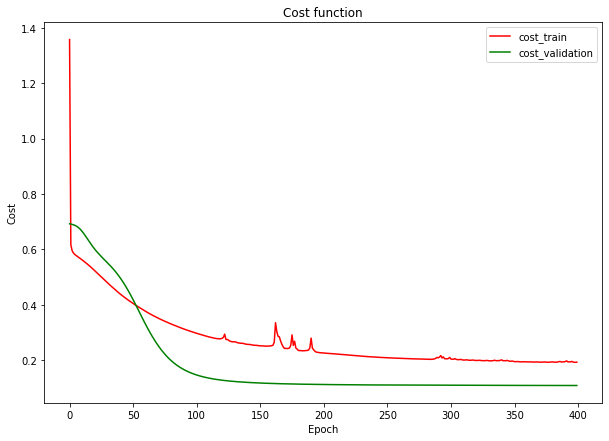

In [ ]:
plt.figure(figsize=(10, 7))

plt.plot(train_losses, color='red')
plt.plot(valid_losses, color='green')
plt.title('Cost function')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend(['cost_train', 'cost_validation'])
plt.show()

##Hacemos inferencias

In [ ]:
print(df_test.iloc[0,2])
print(df_test.iloc[0,0])

gung hay fat choy and a happy yearofthedog to all who are celebrating the chinesenewyear
Democrat


In [ ]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor(dataset.vectorizer.transform([text]).toarray())

        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            return 'Republican'
            
      
        else:
            return 'Democrat'



In [ ]:
print(predict_sentiment(df_test.iloc[100,2]))
print(df_test.iloc[100,0])

Democrat
Republican


##Lo probamos sobre todo el conjunto de prueba

In [ ]:
for i in range(len(df_test["Tweet"].tolist())):
  print('La predicción es:',predict_sentiment(df_test.iloc[i,2]))
  print('La etiqueta real es:',df_test.iloc[i,0],'\n')

In [ ]:
list=[]

for j in range(len(df_test["Tweet"].tolist())):

  if predict_sentiment(df_test.iloc[j,2])==df_test.iloc[j,0]:
    #print('match')
    list.append(1)

acc=sum(list)/len(df_test["Tweet"].tolist())

print('La presición es de :',acc*100,'%')



La presición es de : 63.3472125838538 %


Esto no nos debe de sorprender ya que en la gráfica pudimos ver que nuestro modelo tiene underfitting

##Sugerencias para mejorar los resultados


*   Usar el método de Lemmatize y Replace Rare Words para el vocabulario obtenido

<img src='https://drive.google.com/uc?id=1QG36gHZZzi3zAkLSG2RalW9ogZAqHf7P' align = "center">

*   Tratar de utilizar textos más largos 

*   Aumentar la complejidad de la red

*  Aumentar las épocas

*  Limpiar mejor los datos


